# 3. Apply Model
This step aims to apply the trained model to PlanetScope imagery, where the bands have already been described. The goal is to perform predictions to the data, especially to classify the benthic habitat.

In [40]:
# Import library
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import numpy as np
import matplotlib.pyplot as plt
import joblib

In [ ]:
# Open raster file
dataset = rasterio.open(r"Data\Masked_PS_Gili_with_descriptions.tif")

# Import AOI (Area of Interest)
aoi = gpd.read_file(r"AOI_Polygon.geojson")

# Load the saved model and check the number of classes
loaded_model = joblib.load(r"Model\benthic_xgb_model.pkl")
print(f"Number of classes in the model: {loaded_model.classes_}")
      

Number of classes in the model: [0 1 2 3 4 5]


## Classification Function
Create function to classify the each pixel of the raster data to predict it class. This function also reshapes raster data to prepare it for prediction and excludes invalid (NaN) pixels during the process.

In [42]:
# Apply the model to classify the entire raster image
def classification(raster, model):
    raster_data = raster.read().reshape((raster.count, -1)).T  # Reshape to (pixels, bands)
    nan_mask = np.isnan(raster_data).any(axis=1)  # Identify and exclude pixels with NaN values

    # Create an array to store the classification results
    classified = np.full(raster_data.shape[0], -9999, dtype=int)  # Fill with a NoData value

    # Predict the class only for valid (non-NaN) pixels
    classified[~nan_mask] = model.predict(raster_data[~nan_mask])
    
    # Reshape the classified data back to the original raster dimensions
    return classified.reshape((raster.height, raster.width))


Apply the classification function, checks and prints the unique classes detected in the classified raster. Then it will calculate and show the distribution of each class (how many pixels belong to each class) in the classification result.

In [43]:
# Check the number of detected classes
classify_raster = classification(dataset, loaded_model)
print(f"Number of detected classes: {np.unique(classify_raster)}")
print(np.unique(classify_raster))  # Display detected classes

# Class distribution in the classification result
unique, counts = np.unique(classify_raster, return_counts=True)
print("Class distribution in the classification result:", dict(zip(unique, counts)))

Number of detected classes: [0 1 2 3 4 5]
[0 1 2 3 4 5]
Class distribution in the classification result: {0: 2509566, 1: 158565, 2: 170809, 3: 16996, 4: 211226, 5: 4525}


## Visualize classification result
There is no issue with the classification output; however, it still needs to be masked with shallow water polygons to exclude the Rock class, which has been mistakenly identified as land and deep water. The color codes are taken from the [Allen Coral Atlas (ACA) catalog](https://developers.google.com/earth-engine/datasets/catalog/ACA_reef_habitat_v2_0) in Google Earth Engine.

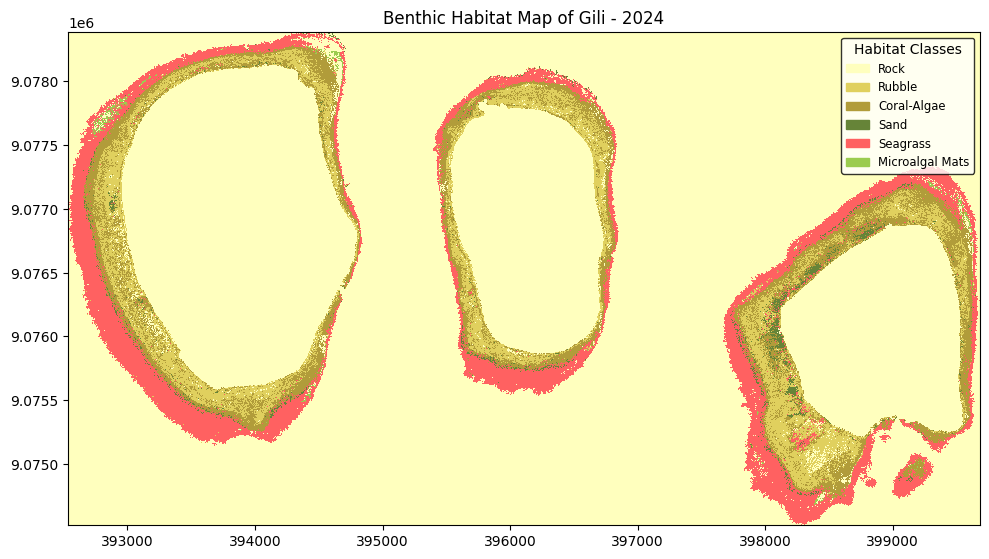

In [44]:
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# Define legend and colors for each class
legend_labels = ['Rock', 'Rubble', 'Coral-Algae', 'Sand', 'Seagrass', 'Microalgal Mats']
legend_colors = ['#ffffbe', '#e0d05e', '#b19c3a', '#668438', '#ff6161', '#9bcc4f']

# Create a figure for the classification map
fig, ax = plt.subplots(figsize=(10, 8))

# Define colormap
cmap = ListedColormap(legend_colors)

# Display the classification map
im = ax.imshow(classify_raster, cmap=cmap, interpolation='nearest',
               extent=[aoi.total_bounds[0], aoi.total_bounds[2], aoi.total_bounds[1], aoi.total_bounds[3]])
ax.set_title('Benthic Habitat Map of Gili Islands - 2024')

# Create legend
legend_handles = [mpatches.Patch(color=legend_colors[i], label=legend_labels[i]) for i in range(len(legend_labels))]

# Add legend to the plot
ax.legend(handles=legend_handles, loc='upper right', title="Habitat Classes",
          fontsize='small', title_fontsize='medium', edgecolor="black", fancybox=True)

# Save the plot and display
plt.tight_layout()
plt.savefig(r"Export\Benthic_Habitat_Map_Gili_2024.jpeg", dpi=600)
plt.show()


### Export the classification Result
Export the result into raster (.tif) to ensure it can be easily loaded an analyzied in GIS software.

In [45]:
import rasterio
from rasterio.transform import from_origin
import numpy as np

def export_classification(classified_map, reference_raster, output_path):
    # Get metadata from the reference raster and update it for the classification output
    meta = reference_raster.meta.copy()
    meta.update({
        "driver": "GTiff",   # Specify GeoTIFF format
        "dtype": 'int32',    # Integer type for class labels
        "count": 1,          # Single-band raster
        "compress": 'lzw',   # Optional compression for smaller file size
        "nodata": -9999      # Define NoData value for transparent areas in GIS
    })

    # Write the classified map with defined NoData value
    with rasterio.open(output_path, 'w', **meta) as dst:
        dst.write(classified_map.astype('int32'), 1)

    print(f"Exported classified map to {output_path} with unique values:", np.unique(classified_map))


# Define the output file path and apply the export function
output_tif_path = r"Export\Habitat_Benthic_Gili_2024_xgb_1123213.tif"
classified_map_filled = export_classification(classify_raster, dataset, output_tif_path)

# Confirm the exported data
print("Data values that will be saved:", np.unique(classified_map_filled))


Exported classified map to Export\Habitat_Benthic_Gili_2024_xgb_1123213.tif with unique values: [0 1 2 3 4 5]
Data values that will be saved: [None]
